In [55]:
########################################################################################
#
# Advanced ConvNet50 for Detecting Simpsons Characters Trained with Transfer Learning
#
# RESNET50 - CNN - TRANSFER LEARNING - DATA AUGMENTATION - KAGGLE DATASET
#
# Luca Amore <luca.amore at gmail.com>
# https://www.lucaamore.com
#
# kaggle:
# https://www.kaggle.com/code/lucaamore/convnet50-simpson-character-identifer
#
# blob post:
# https://www.lucaamore.com/?p=2301
#
# dataset:
# https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
#
########################################################################################

![CNN Simpson](https://www.lucaamore.com/wp-content/uploads/2024/11/simpson-cnn-little.png)

In [56]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os

In [57]:
##########################################################################################################
#
# Step 1: Dataset Acquisition & Preprocessing
#
# This initial phase is crucial, as it lays the foundation for our model's success.
# Here, the focus is on obtaining a well-structured and representative dataset,
# ensuring the raw data is transformed into a format that can be effectively ingested by our model.
#
##########################################################################################################

In [58]:
import kagglehub

# Download latest version of dataset
path = kagglehub.dataset_download("alexattia/the-simpsons-characters-dataset")

print("Path to dataset files:", path)

data_dir = os.path.join(path, 'simpsons_dataset')

Path to dataset files: /kaggle/input/the-simpsons-characters-dataset


In [59]:
# Scan all directories to identify classes in the original dataset

# Define the static parameters
batch_size = 32
img_height = 128
img_width = 128

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True)

num_classes = len(train_ds.class_names)
class_names = train_ds.class_names

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Found 41866 files belonging to 43 classes.
Using 33493 files for training.
Found 41866 files belonging to 43 classes.
Using 8373 files for validation.
Number of classes: 43
Class names: ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'simpsons_dataset', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


In [60]:
from collections import Counter

# we obtain a dictionary `class_counts_named` that maps each
# character to the number of images available, which can then be analyzed
# or visualized to understand the dataset's structure.

class_names_list = [train_ds.class_names[label.numpy()] for _, label in train_ds.unbatch()]

# Initialize an empty Counter
class_counts_named = Counter(class_names_list)

class_counts_named.pop('simpsons_dataset', None)

# Sort the dictionary by count in descending order and print each key-value pair
for label, count in sorted(class_counts_named.items(), key=lambda item: item[1], reverse=True):
    print(f"{label}: {count}")

homer_simpson: 1788
moe_szyslak: 1148
ned_flanders: 1145
lisa_simpson: 1087
bart_simpson: 1061
marge_simpson: 1030
principal_skinner: 964
krusty_the_clown: 957
charles_montgomery_burns: 948
milhouse_van_houten: 859
chief_wiggum: 784
abraham_grampa_simpson: 733
sideshow_bob: 695
apu_nahasapeemapetilon: 498
kent_brockman: 394
edna_krabappel: 383
comic_book_guy: 372
nelson_muntz: 287
lenny_leonard: 251
mayor_quimby: 198
waylon_smithers: 144
groundskeeper_willie: 100
maggie_simpson: 99
selma_bouvier: 81
barney_gumble: 80
carl_carlson: 75
ralph_wiggum: 63
patty_bouvier: 56
martin_prince: 52
professor_john_frink: 49
snake_jailbird: 43
rainier_wolfcastle: 39
cletus_spuckler: 38
sideshow_mel: 33
agnes_skinner: 33
otto_mann: 27
fat_tony: 22
gil: 21
miss_hoover: 15
troy_mcclure: 8
disco_stu: 7
lionel_hutz: 3


In [61]:
# To ensure a balanced training dataset, we may want to include only characters
# with a minimum number of images. This helps prevent the model from being biased
# towards characters with more data and improves overall classification accuracy.

# Minimum image threshold required for a class
img_min_num = 200

# Identify classes with more than img_min_num images
classes_over_img_min_num = {label for label, count in class_counts_named.items() if count >= img_min_num}

# Classes with more than img_num images
for label, count in sorted(class_counts_named.items(), key=lambda item: item[1], reverse=True):
    print(f"{label}: {count}") if label in classes_over_img_min_num else None


homer_simpson: 1788
moe_szyslak: 1148
ned_flanders: 1145
lisa_simpson: 1087
bart_simpson: 1061
marge_simpson: 1030
principal_skinner: 964
krusty_the_clown: 957
charles_montgomery_burns: 948
milhouse_van_houten: 859
chief_wiggum: 784
abraham_grampa_simpson: 733
sideshow_bob: 695
apu_nahasapeemapetilon: 498
kent_brockman: 394
edna_krabappel: 383
comic_book_guy: 372
nelson_muntz: 287
lenny_leonard: 251


In [62]:
# Reload the dataset, including only classes with an adequate number of images

train_ds = image_dataset_from_directory(
    data_dir,
    class_names=classes_over_img_min_num,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True)

val_ds = image_dataset_from_directory(
    data_dir,
    class_names=classes_over_img_min_num,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True)

num_classes = len(train_ds.class_names)
class_names = list(train_ds.class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Found 19302 files belonging to 19 classes.
Using 15442 files for training.
Found 19302 files belonging to 19 classes.
Using 3860 files for validation.
Number of classes: 19
Class names: ['lisa_simpson', 'homer_simpson', 'krusty_the_clown', 'nelson_muntz', 'moe_szyslak', 'charles_montgomery_burns', 'abraham_grampa_simpson', 'lenny_leonard', 'apu_nahasapeemapetilon', 'chief_wiggum', 'principal_skinner', 'bart_simpson', 'comic_book_guy', 'sideshow_bob', 'edna_krabappel', 'marge_simpson', 'ned_flanders', 'kent_brockman', 'milhouse_van_houten']


Dataset: /kaggle/input/the-simpsons-characters-dataset/simpsons_dataset


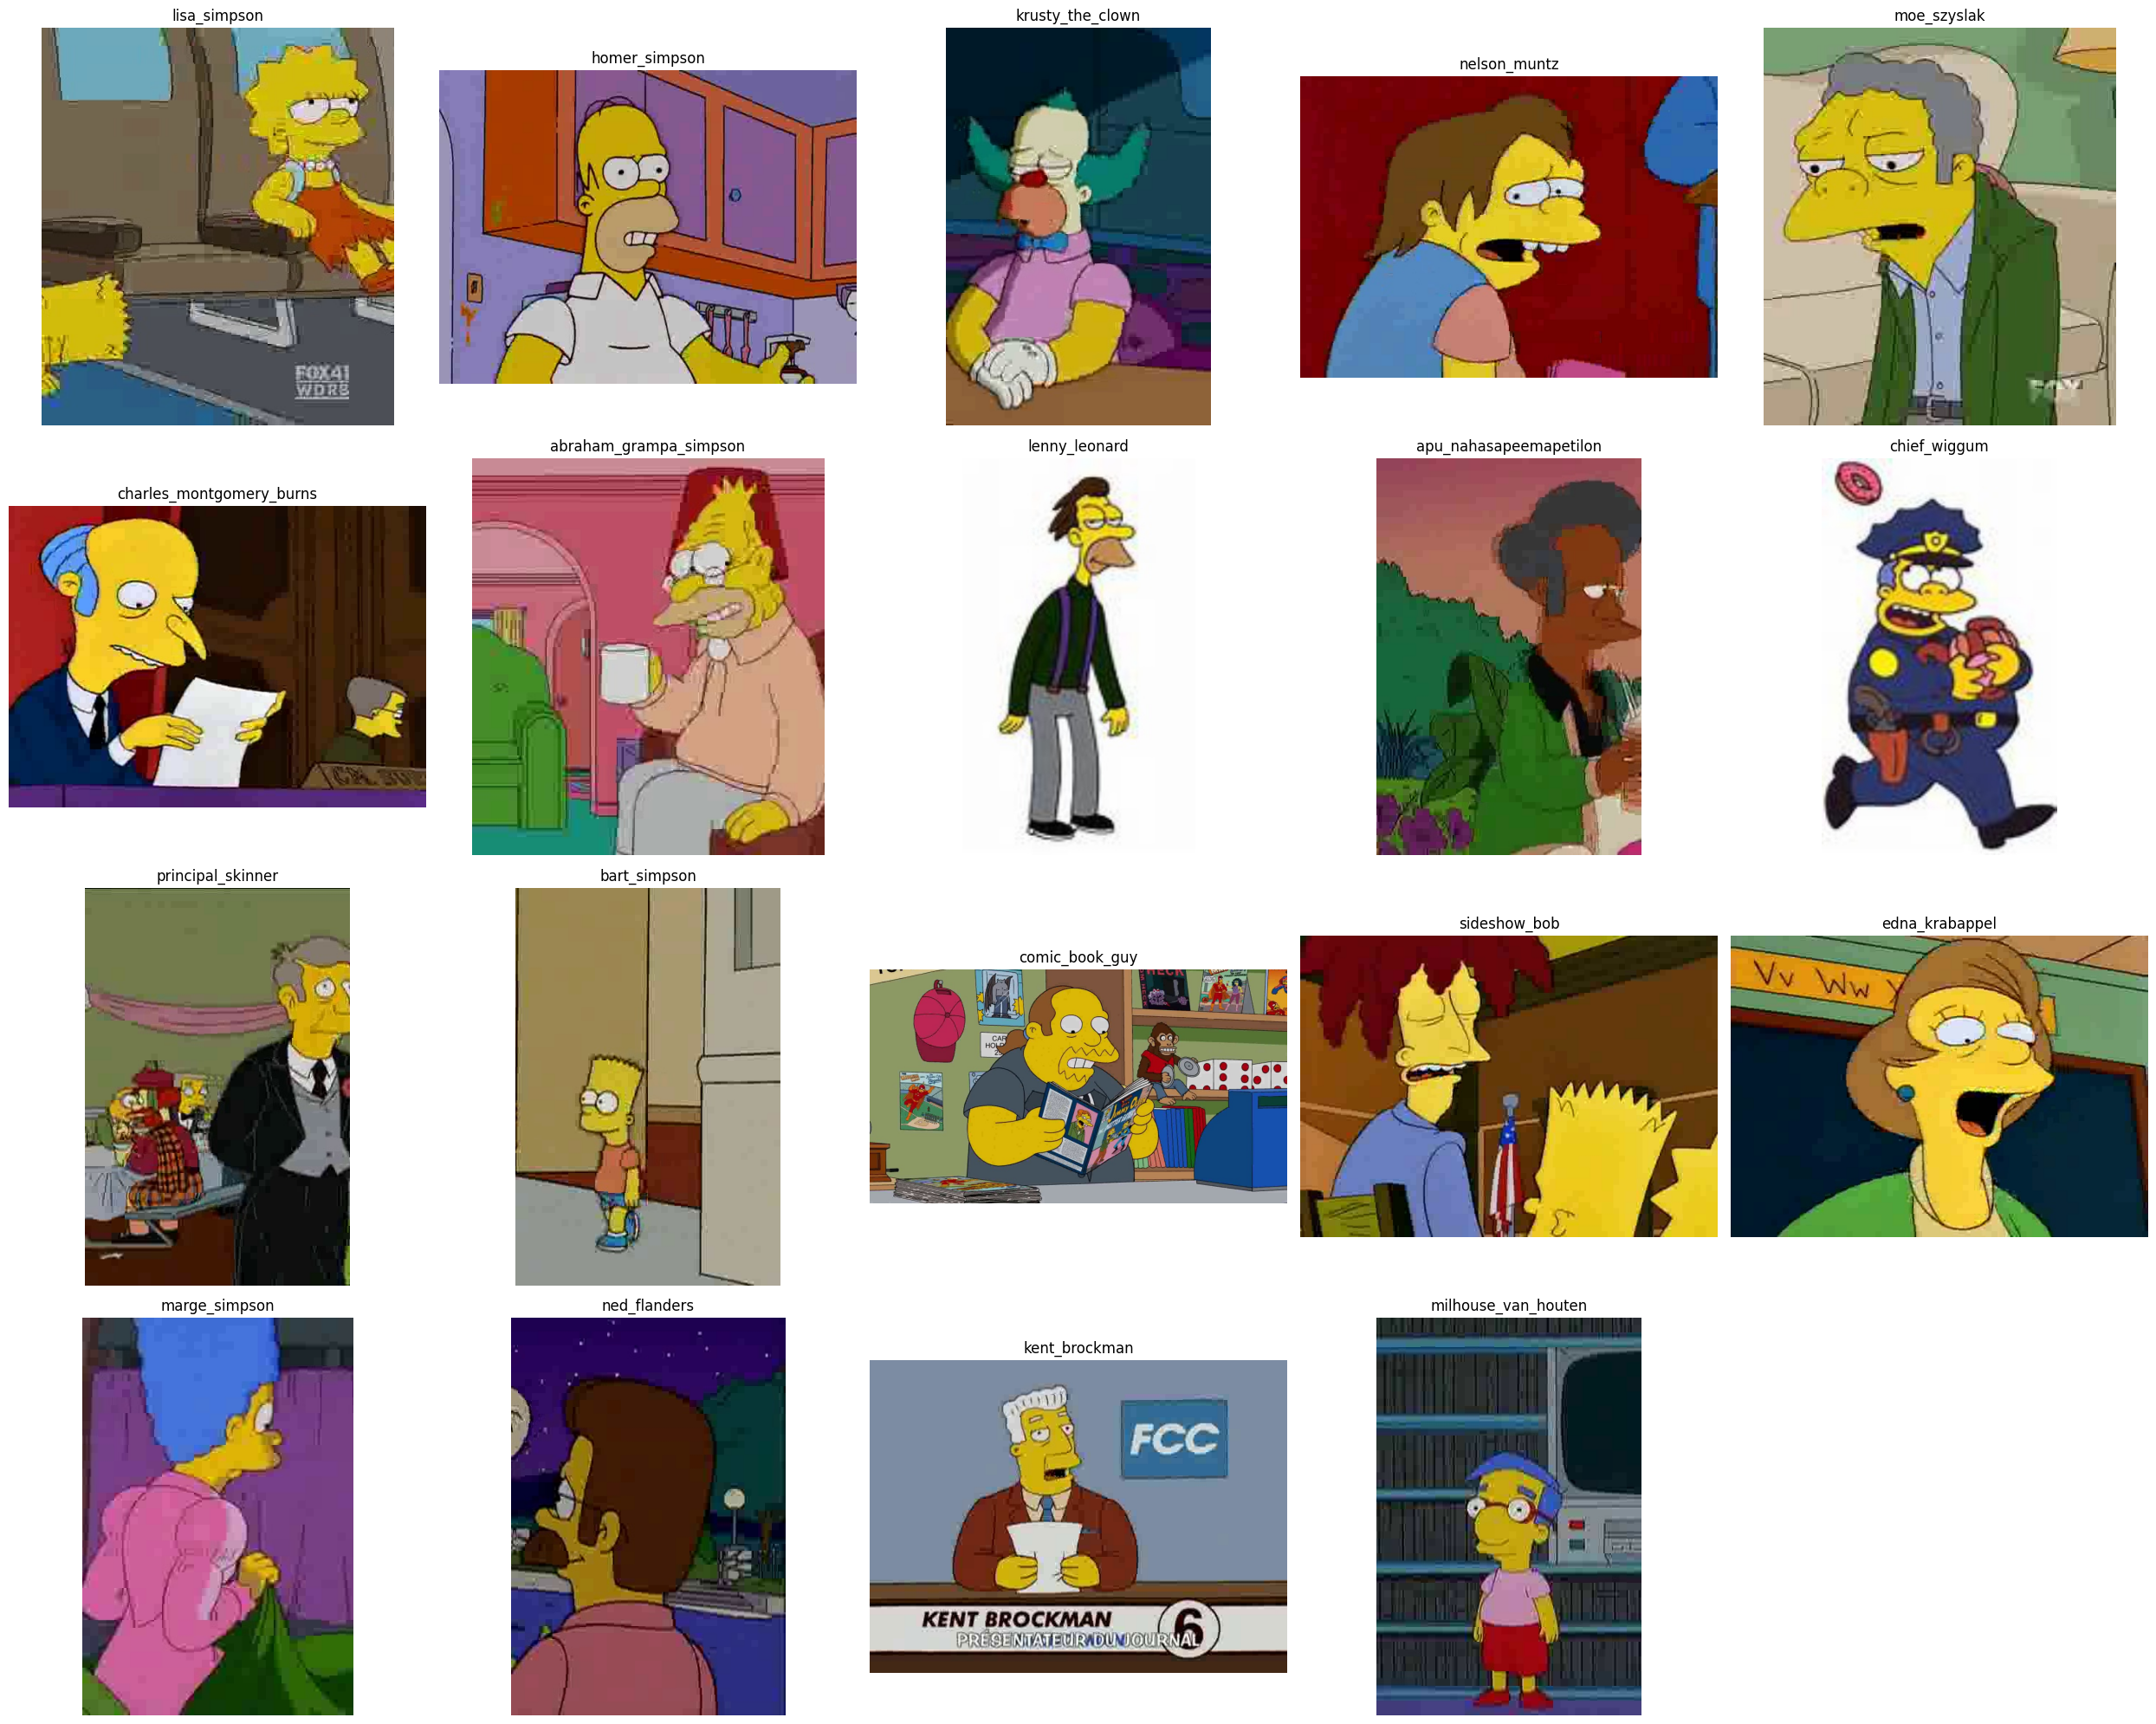

In [63]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import math

# show all recognized characters

# Assuming data_dir and train_ds are already defined
print(f"Dataset: {data_dir}")

# Get the list of classes (subdirectories)
classes = train_ds.class_names

# Parameters
max_columns = 5

# Calculate number of rows and columns
num_classes = len(classes)
num_columns = min(num_classes, max_columns)
num_rows = math.ceil(num_classes / max_columns)

# Create a figure to display the images
fig, axs = plt.subplots(num_rows, num_columns, figsize=(5 * num_columns, 5 * num_rows))

# Flatten axs array for easy indexing if necessary
if num_rows == 1:
    axs = [axs]
else:
    axs = axs.flatten()

for idx, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    images = os.listdir(class_path)

    # Select one random image
    selected_image = random.choice(images)

    img_path = os.path.join(class_path, selected_image)
    img = Image.open(img_path)

    ax = axs[idx]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{class_name}")

# Hide any unused subplots
for idx in range(len(classes), len(axs)):
    axs[idx].axis('off')

plt.tight_layout()
plt.show()

In [64]:
##########################################################################################################
#
# Step 2: Building the Model with Transfer Learning using ResNet50 and Augmented Data
#
# In this phase, we leverage the power of transfer learning by adopting a pre-trained ResNet50 model,
# known for its depth and robust feature extraction capabilities. This step allows us to use pre-learned
# knowledge from a large dataset (typically ImageNet), significantly accelerating the training process
# and enhancing performance with fewer data samples.
#
##########################################################################################################

In [65]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# ResNet50 is a 50-layer deep convolutional neural network architecture,
# part of the ResNet (Residual Network) family. It is particularly known
# for its "residual blocks" which help mitigate the vanishing gradient
# problem often encountered in deep networks.

# Why ResNet50 for Simpsons Character Classification?
# 1. Depth and Detail: With its 50 layers, ResNet50 is capable of capturing
#    fine-grained details, crucial for differentiating characters with subtle
#    visual distinctions.
# 2. Pre-trained Performance: Being pre-trained on large datasets like ImageNet,
#    it serves as a strong starting point, reducing the need for extensive
#    training on the Simpsons dataset.
# 3. Residual Learning: The residual connections in ResNet allow it to bypass
#    certain layers, preventing the degradation of features and making it
#    well-suited for transfer learning tasks.

# Alternative Models to Consider:
# - VGG16/19: A simpler model, easier to implement, but resource-intensive and
#   typically requiring more computational power than ResNet50.
# - InceptionV3: Known for its multi-scale convolution approach, which can
#   capture variations in character appearances effectively.
# - MobileNet: A lightweight and efficient model, suitable if computational
#   resources are limited, though it may lack the depth required for high
#   precision in subtle classifications.
# - EfficientNet: Offers excellent scalability across different image resolutions
#   and sizes, delivering state-of-the-art accuracy with a more efficient
#   structure, though it may be more complex to set up.

# Each of these alternatives offers unique strengths depending on the computational
# constraints and the specific requirements of the classification task.

# Preprocess image for ResNet50
def preprocess_resnet50(images, labels):
    images = preprocess_input(images)
    return images, labels

# Preprocess all images of entire dataset
train_ds = train_ds.map(preprocess_resnet50)
val_ds = val_ds.map(preprocess_resnet50)

# Import ResNet50 for transfer learning
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Congela i pesi del modello base



In [66]:

# Data Augmentation - Purpose
# Data augmentation is used to artificially increase the size and variability
# of the training dataset by applying transformations such as rotations,
# flips, and zooms to the original images.

# Why Use Data Augmentation?
# 1. Prevents Overfitting: By generating varied versions of the same images,
#    it helps the model generalize better to new, unseen data.
# 2. Enhances Model Robustness: Data augmentation exposes the model to different
#    perspectives and variations, making it more resilient to real-world scenarios.
# 3. Compensates for Limited Data: Especially useful in cases where collecting
#    a large dataset is challenging, as it effectively increases the data volume
#    without new samples.

# Preprocessing for data augmentation
data_augmentation = models.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    #layers.RandomContrast(0.1),
])



In [67]:
# Enrich the ResNet50 base model for transfer learning
# This model leverages transfer learning by using a pre-trained base model as a fixed
# feature extractor, and builds upon it with custom dense layers tailored to the target
# classification task.
model = models.Sequential([
    data_augmentation,
    base_model,
    #layers.Flatten(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [68]:
##########################################################################################################
#
# Step 3: Training and Post-Training of the Model
#
# In this final phase, we take our prepared model architecture and train it with the preprocessed dataset.
# Here, every step is critical, from selecting the right number of epochs to monitoring performance metrics,
# ensuring the model learns effectively without overfitting or underfitting.
#
##########################################################################################################

In [69]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Callback functions during the learning phase
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Optimizer parameters
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )

In [ ]:
# Training epochs
epochs = 50

# Start training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.2421 - loss: 2.7116 - val_accuracy: 0.5516 - val_loss: 1.5244 - learning_rate: 0.0010
Epoch 2/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.4332 - loss: 1.8730 - val_accuracy: 0.6023 - val_loss: 1.3253 - learning_rate: 0.0010
Epoch 3/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.4840 - loss: 1.6885 - val_accuracy: 0.6412 - val_loss: 1.2412 - learning_rate: 0.0010
Epoch 4/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.5143 - loss: 1.5901 - val_accuracy: 0.6694 - val_loss: 1.1315 - learning_rate: 0.0010
Epoch 5/50
390/483 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5513 - loss: 1.5111

In [ ]:
model.save('simpson.keras')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Loss and Accuracy Graphs
# During model training, we monitor two key metrics over each epoch: loss and accuracy.
# These graphs are essential for evaluating model performance and diagnosing issues.
# - The loss graph shows the "loss" value (or error) over each training epoch.
# - The accuracy graph shows the model's accuracy over each epoch, reflecting the
#   percentage of correct predictions.

def loss_accuracy_graph(history):

  # Convert training history data to a DataFrame
  history_frame = pd.DataFrame(history.history)

  # Set figure size for the plots
  plt.figure(figsize=(12, 5))

  # Plot for loss (training and validation)
  plt.subplot(1, 2, 1)  # Create the first subplot for loss
  plt.plot(history_frame['loss'], label='Training Loss')  # Plot training loss
  plt.plot(history_frame['val_loss'], label='Validation Loss')  # Plot validation loss
  plt.xlabel('Epochs')  # Label for x-axis
  plt.ylabel('Loss')  # Label for y-axis
  plt.title('Training and Validation Loss')  # Title for the loss plot
  plt.legend()  # Display legend to differentiate lines
  plt.grid(True)  # Add a grid for better readability

  # Plot for accuracy (training and validation)
  plt.subplot(1, 2, 2)  # Create the second subplot for accuracy
  plt.plot(history_frame['accuracy'], label='Training Accuracy')  # Plot training accuracy
  plt.plot(history_frame['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
  plt.xlabel('Epochs')  # Label for x-axis
  plt.ylabel('Accuracy')  # Label for y-axis
  plt.title('Training and Validation Accuracy')  # Title for the accuracy plot
  plt.legend()  # Display legend to differentiate lines
  plt.grid(True)  # Add a grid for better readability

  # Adjust layout for proper spacing between subplots
  plt.tight_layout()
  plt.show()


In [ ]:
loss_accuracy_graph(history)

In [ ]:
# Fine-tuning is an additional step in transfer learning, where we "unlock" and train
# some of the layers in the pre-trained base model. This approach allows the model
# to adapt high-level features more specifically to the new dataset.

additional_epochs=30
fine_tune_start_layer = 50

# Unfreeze the base model
base_model.trainable = True

# Freeze all layers up to the nth layer
fine_tune_at = len(base_model.layers) - fine_tune_start_layer

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Resume model training with a reduced learning rate
from tensorflow.keras.optimizers import Adam

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7),
    ModelCheckpoint('best_model_fine.keras', save_best_only=True)
]

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=additional_epochs,
                         callbacks=callbacks)


In [ ]:
model.save('simpson_fine.keras')

In [ ]:
loss_accuracy_graph(history_fine)

In [ ]:
##########################################################################################################
#
# Step 4: Validation of Model Functionality
#
# This phase is essential for rigorously assessing how well our model generalizes to unseen data and
# ensuring its performance meets the project's expectations. Here, we validate the model not only on
# accuracy metrics but also on other relevant measures, including error analysis and confusion matrix
# evaluations.
#
##########################################################################################################

In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

# Evaluation metrics provide insight into a model's performance by quantifying
# its ability to make accurate predictions. In classification tasks, different
# metrics capture different aspects of performance. Here are some commonly used metrics:

# 1. Accuracy:
# - Measures the proportion of correct predictions out of the total predictions.
# - Useful for balanced datasets where all classes are equally important.
# - Formula: Accuracy = (True Positives + True Negatives) / Total Predictions.

# 2. Precision:
# - Indicates how many of the predicted positive results are actually correct.
# - Important for tasks where false positives are costly (e.g., spam detection).
# - Formula: Precision = True Positives / (True Positives + False Positives).

# 3. Recall (Sensitivity or True Positive Rate):
# - Measures the ability to correctly identify all actual positives.
# - Crucial in tasks where missing positive instances is costly (e.g., medical diagnoses).
# - Formula: Recall = True Positives / (True Positives + False Negatives).

# 4. F1 Score:
# - The harmonic mean of Precision and Recall, providing a single metric for
#   evaluating both false positives and false negatives.
# - Useful for imbalanced datasets or cases where both Precision and Recall are important.
# - Formula: F1 Score = 2 * (Precision * Recall) / (Precision + Recall).

# 5. Confusion Matrix:
# - A matrix that displays the counts of true positive, true negative, false positive,
#   and false negative predictions.
# - Provides a detailed view of classification performance for each class, helping to
#   identify which classes are often misclassified.

# Choosing the Right Metric:
# - **Balanced Datasets**: Accuracy is often sufficient.
# - **Imbalanced Datasets**: Precision, Recall, and F1 Score are more informative, as
#   they account for false positives and false negatives.
# - **Threshold-Based Tasks**: AUC-ROC is ideal for evaluating models where threshold
#   adjustment impacts performance.


# Define a function to evaluate the model on a given dataset
def evaluate_model(model, dataset, dataset_name):

    #Evaluates the model on the given dataset and prints out various metrics.

    # Initialize lists to store true labels and predicted labels
    y_true = []
    y_pred = []

    # Iterate over the dataset batches
    for batch_x, batch_y in dataset:
        # Make predictions on the input batch
        predictions = model.predict(batch_x, verbose=0)
        # Convert predictions to class labels (assuming multi-class classification)
        predicted_labels = np.argmax(predictions, axis=1)
        # If labels are one-hot encoded, convert them back to class labels
        if len(batch_y.shape) > 1 and batch_y.shape[1] > 1:
            true_labels = np.argmax(batch_y.numpy(), axis=1)
        else:
            true_labels = batch_y.numpy()
        # Append the labels to the lists
        y_true.extend(true_labels)
        y_pred.extend(predicted_labels)

    # Convert lists to NumPy arrays for metric computations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    # Print out the metrics
    print(f"----- Metrics for {dataset_name} -----")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}\n")

    # Print classification report
    print("Classification Report:")
    model_classification_report=classification_report(y_true, y_pred, zero_division=0, target_names=class_names)
    print(model_classification_report)

    # Show confusion matrix
    print("Confusion Matrix:")
    model_confusion_matrix=confusion_matrix(y_true, y_pred)
    #print(model_confusion_matrix)

    plt.figure(figsize=(12, 6))
    sns.heatmap(model_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes_over_img_min_num, yticklabels=classes_over_img_min_num)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    print("--------------------------------------\n")



In [ ]:
# Evaluate the model on the training dataset
evaluate_model(model, train_ds, "Training Dataset")


In [ ]:
# Evaluate the model on the validation dataset
evaluate_model(model, val_ds, "Validation Dataset")


In [ ]:
##########################################################################################################
#
# Step 5: Demonstrating the Functionality of the Trained Model with Unseen Images
#
# In this phase, we put the trained model to the test by running a live demonstration with images that
# were not part of the training, validation, or test sets. This real-world test showcases the model's
# practical application and its ability to generalize to entirely new data.
#
##########################################################################################################

In [ ]:
# When visualizing images processed by ResNet50, we need to "deprocess"
# them, as the model applies specific preprocessing (e.g., normalization)
# during training. This function reverses that preprocessing to convert images
# back to a human-readable format.

def deprocess_resnet50_image(img):
    # ResNet50 uses the mean [123.68, 116.779, 103.939] in RGB order
    img[..., 0] += 123.68   # R channel
    img[..., 1] += 116.779  # G channel
    img[..., 2] += 103.939  # B channel

    # Convert from BGR to RGB for visualization
    img = img[..., ::-1]

    # Convert from RGB to valid display values
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

val_ds_unbatched = val_ds.unbatch()

# Calculate the total number of examples in the validation dataset
num_val_examples = 50000

# Shuffle individual images with buffer_size equal to total number of examples
shuffled_val_ds = val_ds_unbatched.shuffle(buffer_size=num_val_examples, reshuffle_each_iteration=True)

# Define the number of images to display
num_images = 50  # You can adjust this value

# Pick num_images random images from the unpacked, shuffled dataset
random_images = []
random_labels = []

for image, label in shuffled_val_ds.take(num_images):
    random_images.append(image.numpy())
    random_labels.append(label.numpy())

# Convert lists to NumPy arrays
random_images = np.array(random_images)
random_labels = np.array(random_labels)

# Make predictions on these random images
predictions = model.predict(random_images)
predicted_classes = np.argmax(predictions, axis=1)  # Get predicted classes
confidences = np.max(predictions, axis=1)  # Get confidence level for each prediction

# Calculate layout for subplots
num_cols = min(5, num_images)
num_rows = (num_images + num_cols - 1) // num_cols

# Display images with true and predicted labels
plt.figure(figsize=(4 * num_cols, 4 * num_rows))
for i in range(num_images):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(deprocess_resnet50_image(random_images[i]))

    true_label = class_names[random_labels[i]]
    predicted_label = class_names[predicted_classes[i]]
    confidence = confidences[i] * 100  # Convert to percentage

    # Title with true class, predicted class, and confidence
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}%")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
##########################################################################################################
#
# Step 6: Information on Model Architecture
#
# In this step, we dive into the specifics of the model’s architecture, describing the structure of each
# layer and the role it plays in the overall network. Understanding the architecture allows for better
# insight into how the model processes data and extracts features at various depths.
#
##########################################################################################################

In [ ]:
model.summary()

In [ ]:
##########################################################################################################
# Final Results
#
# This section summarizes the key results obtained from evaluating the model on the validation set.
# These results provide a clear picture of how well the model is performing, its strengths, and any areas
# for potential improvement.
##########################################################################################################

In [ ]:
# Evaluate the model on the validation dataset
evaluate_model(model, val_ds, "Validation Dataset")

![genius](https://www.lucaamore.com/wp-content/uploads/2024/11/simpson-accuraciy.webp)